Refracted gaussian processes code

In [8]:
import numpy as np
import numpy.matlib as matlib
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
### plot font size params ###

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE, weight = 'bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, labelsize = SMALL_SIZE, labelweight = 'bold')     # fontsize of the axes title, x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True

Kernel Functions

In [4]:
# Squared exponential covariance function
def Kexp(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    d = hyps[1:]

    Ksum = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) )
        
        Ksum += float( d[i] ) * np.square(Kdiff) 
    
    K = a * np.exp( -0.5 * Ksum )
    
    return K

# Trace(A*B) function to save computational time
def traceAB(A,B): 
    '''
    Calculates trace of A*B
    '''
    # A and B assumed to be square
    n = A.shape[0]

    trace = float(0)

    for i in range(0,n):
        trace += float( A[i,:] @ B[:,i] ) 
    
    return trace

# diag-add function
def diagAdd(v,A):
    '''
    Adds scalar value to the diagonal of A
    '''
    # n = A.shape[0]
    B = np.copy(A)
    np.fill_diagonal(B, B.diagonal() + v) 
    

    # for i in range(0,n):
        
    #     A[i,i] += v

    return B


# Negative log-likelihood function (constants and scaling removed)
def nLL(log_hyps,x,y):
    '''
    Calculates the negative log likelihood given hyperparameters, inputs x and outputs y
    '''

    hypsK = np.exp ( log_hyps[:-1] )

    v =  np.exp( log_hyps[-1] ) 

    K = Kexp(hypsK,x,x) 

    # Add noise variance and invert
    Q = diagAdd(v,K)
    invQ = la.inv(Q)

    # Numerically stable calculation  of logdet(Q)
    log_det = np.sum( np.log ( la.svd(Q)[1] ) )  

    negLogLike = float( np.transpose(y) @ invQ @ y + log_det )
    
    return negLogLike

# nLL Jacobian function
def DnLL(log_hyps,x,y):
    '''
    Calculates the gradient of the negative log likelihood given hyperparameters, inputs x and outputs y
    '''
    n = x.shape[0]
    m = x.shape[1]

    hypsK = np.exp ( log_hyps[:-1] )
    v = float( np.exp( log_hyps[-1] ) )
    
    K = Kexp(hypsK,x,x) 
    
    # Add noise variance and invert
    Omega = diagAdd( v , np.matlib.zeros( (n,n) ) )
    Q = K + Omega 
    # Q = diagAdd( v , K)
    invQ = la.inv(Q)

    yTinvQ = np.transpose(y) @ invQ

    Jac = np.zeros( (m+2,) )

    DaQ = K
    Jac[0] = traceAB(invQ,DaQ) - yTinvQ @ DaQ @ yTinvQ.transpose()

    for i in range(1,m+1):
        
        Kdiff = np.tile( x[:,i-1] , (n,1) ).T - np.tile( x[:,i-1] , (n,1) )
        d = float( hypsK[i] ) 
        DdQ = np.multiply( np.matrix( -d/2 * np.square(Kdiff) ) , K ) # pointwise multiplication
        Jac[i] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()
    
    DvQ = Omega
    Jac[m+1] = traceAB(invQ,DvQ) - yTinvQ @ DvQ @ yTinvQ.transpose()

    return Jac

# Perform hyperparameter learning
def hypLearn_exp(x,y):
    '''
    Perform MLE to estimate the hyperparameters from data. 
    Uses the scipy.optimize minimise method to minimise the negloglike.
    '''
    n = x.shape[0]
    m = x.shape[1]

    # define initial log_hyperparameter values for optimisation, drawing them from standard normal dist.
    log_hyps0 = np.random.normal(0,1, (m+2,) )      

    res = minimize( nLL , log_hyps0, (x,y), method = 'BFGS', jac = DnLL, options = {'disp': True}  )
    hyps = np.exp( res.x )
    print('Learned hyperparameters [a,d,v] = ', hyps)
    
    return hyps

# GP predictions
def GPpred(hyps,x,y,x_pred):
    '''
    Make predictions on input domain x_pred.
    '''

    Kx = Kexp(hyps[:-1],x,x)
    Q = diagAdd(hyps[-1],Kx)
    invQ = la.inv(Q)

    Kpx = Kexp(hyps[:-1],x_pred,x)
    Kpp = Kexp(hyps[:-1],x_pred,x_pred)
    
    pred = Kpx @ invQ @ y # GP prediction on x_pred

    cov = Kpp - Kpx @ invQ @ Kpx.transpose() # GP covariance matrix on x_pred
    std = np.sqrt( np.diag( cov ) ).reshape(-1,1) # GP standard deviations on x_pred

    return pred, std

Sample from GP

In [21]:
x = np.arange(0,10,0.1).reshape(-1,1)
N = len(x)

a=2
l=100

K_x = Kexp([a,l],x,x)
w = np.random.randn(N,1)

K_sqrt = np.real(scipy.linalg.sqrtm(K_x))

f = K_sqrt@w

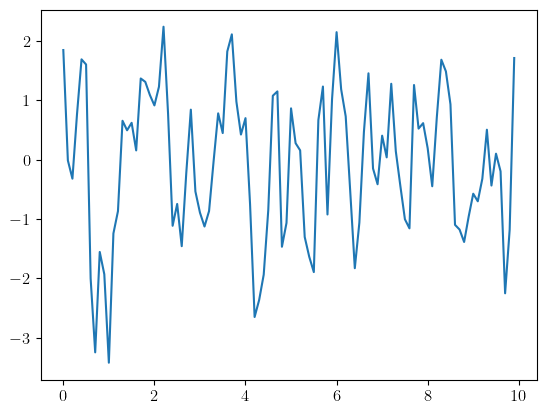

In [22]:
plt.plot(x,f)
plt.show()

Add measurements and sample from posterior

In [78]:
M = 3
x_meas = 10*np.random.rand(M,1)
y_meas = 10*(np.random.rand(M,1) - 0.5)
print(y_meas)

K_x_meas = Kexp([a,l],x_meas,x_meas)

K_x_joint = Kexp([a,l],x,x_meas)

mu_post = K_x_joint@np.linalg.inv(K_x_meas)@y_meas
K_post = K_x - K_x_joint@np.linalg.inv(K_x_meas)@K_x_joint.T
std_post = np.sqrt(np.diag(K_post))

sqrtK = np.real(scipy.linalg.sqrtm(K_post))

[[ 3.26037036]
 [-4.47154103]
 [ 3.86318549]]


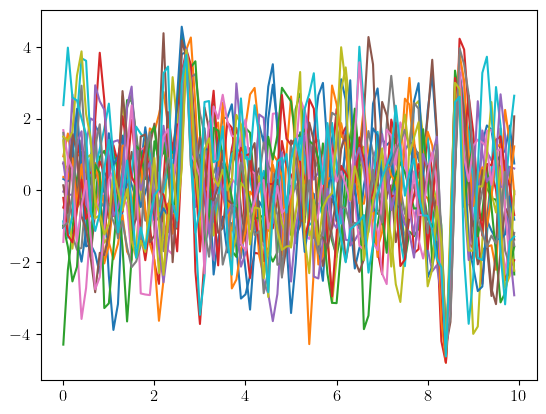

In [79]:
for i in range(20):
    w = np.random.randn(N,1)
    f = sqrtK@w + mu_post
    plt.plot(x,f)

Example of Maximum Likelihood Estimation

In [94]:
def testRun(nRuns = 1):
    '''
    One dimensional case, learning two hyperparameters from a sample of the GP prior with added noise.
    '''
    n = 200
    xmin = 1
    xmax = 20
    x = np.linspace(xmin,xmax,n).reshape(-1,1)

    # define hyps
    a = 1
    d = 1

    Kx = Kexp([a,d],x,x)
    sqrtKx = np.real( la.sqrtm(Kx) )

    sig = 0.2
    y = sqrtKx @ np.random.normal(0,1, (n,1)) +  np.random.normal(0,sig, (n,1) )  

    # Hyperparameter training
    av_hyps =np.array([0,0,0],float)
    for _ in range(nRuns):
        av_hyps += hypLearn_exp(x,y)
    av_hyps = av_hyps/nRuns

    # Make predictions
    pred, std = GPpred(av_hyps,x,y,x)
    
    plt.plot(x,y,'bo',label = 'Prior Sample')
    plt.plot(x,pred, color = 'red',label = 'Prediction')
    plt.plot(x,pred + 2*std, color = 'red', linestyle = '--',)
    plt.plot(x,pred - 2*std, color = 'red', linestyle = '--', label = '+/-2 std')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return av_hyps

# run test code
testRun()

Optimization terminated successfully.
         Current function value: -365.181803
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Learned hyperparameters [a,d,v] =  [0.91569601 0.85344126 0.03670947]
Optimization terminated successfully.
         Current function value: -355.732051
         Iterations: 12
         Function evaluations: 18
         Gradient evaluations: 18
Learned hyperparameters [a,d,v] =  [0.87142947 1.07677156 0.03714756]
Optimization terminated successfully.
         Current function value: -366.384450
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Learned hyperparameters [a,d,v] =  [0.77725969 1.11720365 0.03523242]
Optimization terminated successfully.
         Current function value: -345.769187
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Learned hyperparameters [a,d,v] =  [0.97555645 1.02639311 0.03911826]
Optimization termina

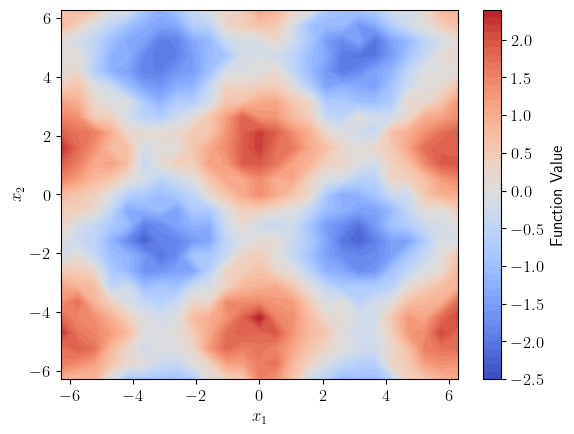

In [121]:
def testRun2(nRuns = 1):
    '''
    Two dimensional case with data generated from trig function, estimating four hyperparameters
    '''
    n = 25
    xmin = -2*np.pi
    xmax = 2*np.pi
    ymin = -2*np.pi
    ymax = 2*np.pi
    
    X, Y = np.meshgrid(
        np.linspace(xmin, xmax, n),
        np.linspace(ymin, ymax, n)
    )
    XY = np.array([list(zip(x,y)) for x,y in zip(X,Y)]).reshape((n*n, 2))

    f = np.cos(XY[:,0]) + np.sin(XY[:,1])

    sig = 0.2
    y = f.reshape(-1,1) + np.random.normal(0,sig, (n*n,1) )

    # plot function surface
    vmin, vmax = (-2.5,2.5)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    levels = np.arange(vmin,vmax,0.1)
    plt.contourf(X, Y, y.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    plt.colorbar(label = 'Function Value')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.show()
  

    # # Hyperparameter training
    # av_hyps =np.array([0,0,0,0],float)
    # for _ in range(nRuns):
    #     av_hyps += hypLearn_exp(XY,y)

    # av_hyps = av_hyps/nRuns

    
    # # Make predictions
    # pred, std = GPpred(av_hyps,XY,y,XY)
    
    # vmin, vmax = (-2.5,2.5)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # levels = np.arange(vmin,vmax,0.1)

    # # plot prediction as surface
    # plt.contourf(X, Y, pred.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = 'Prediction Value')
    # plt.xlabel(r'$x_1$')
    # plt.ylabel(r'$x_2$')
    # plt.show()

    # # plot slice
    # plt.plot(XY.reshape((n,n,2))[0,:,0],f.reshape((n,n))[:,0],'bo',label = 'Data')
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0],color = 'red',label = 'Prediction')
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0]+ 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--', label = '+/-2 std')
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0] - 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--')
    # plt.xlabel(r'$x_1$')
    # plt.ylabel('Value')
    # plt.title(r'$x_2 = 0$')
    # plt.legend()
    # plt.show()
    return #av_hyps
# run test code
testRun2()